<span style="color: red; font-size: 2em; font-weight: bold;">Example 4: Wind Generator+Storage Unit - Load </span>

Network Connections:
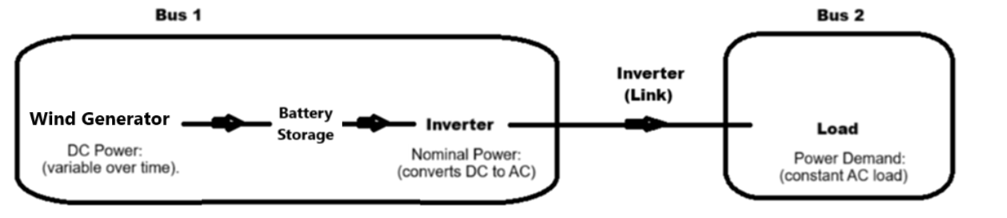

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.39s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


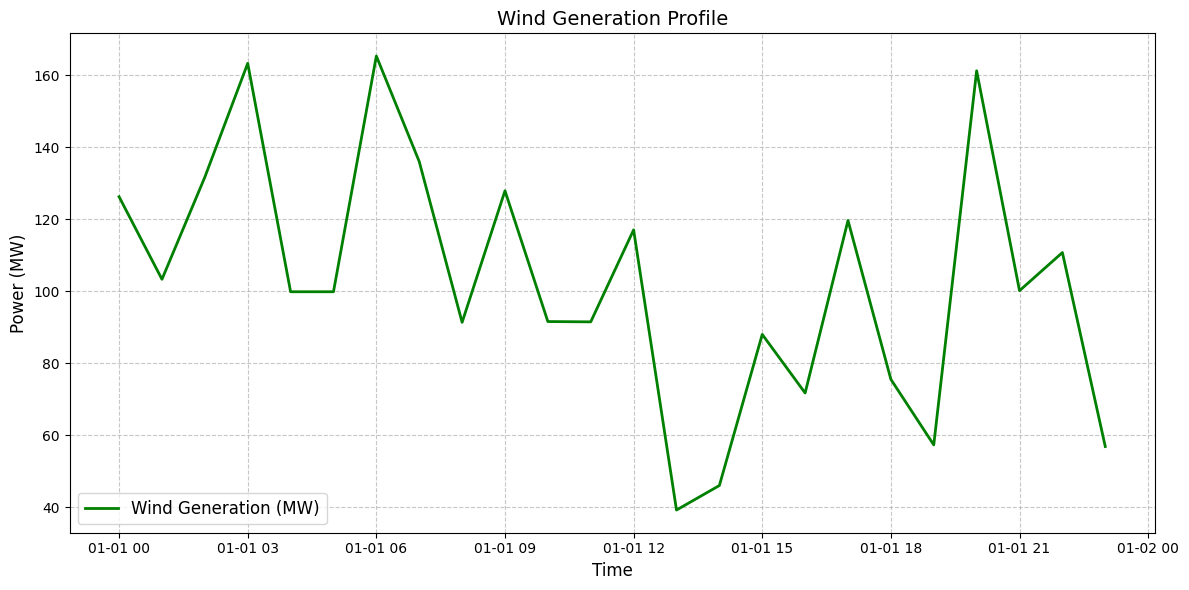

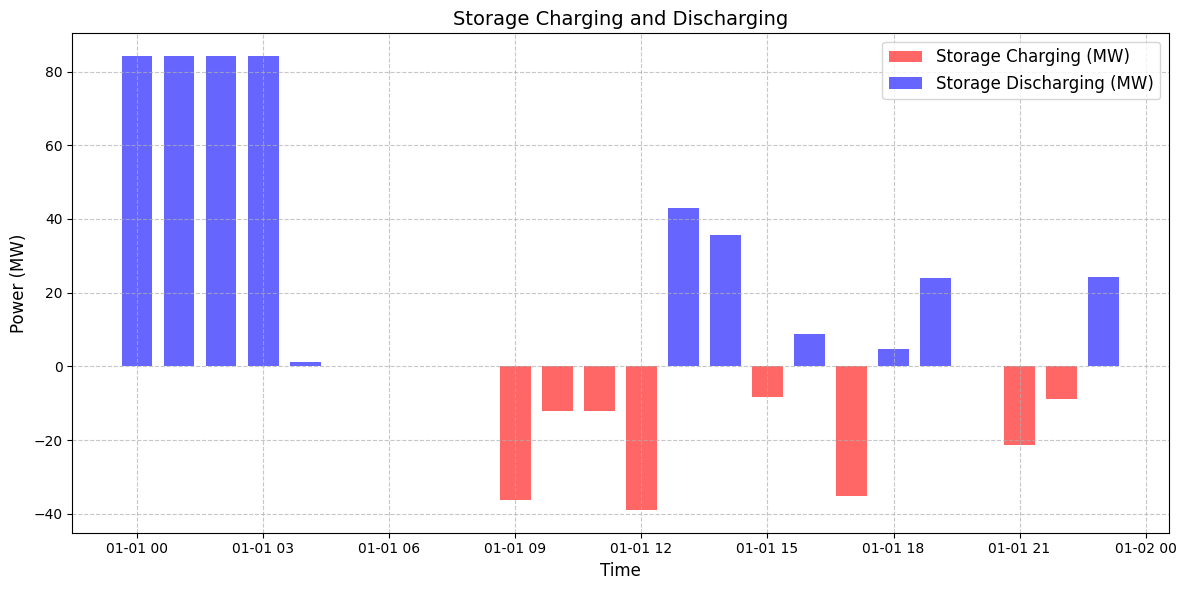

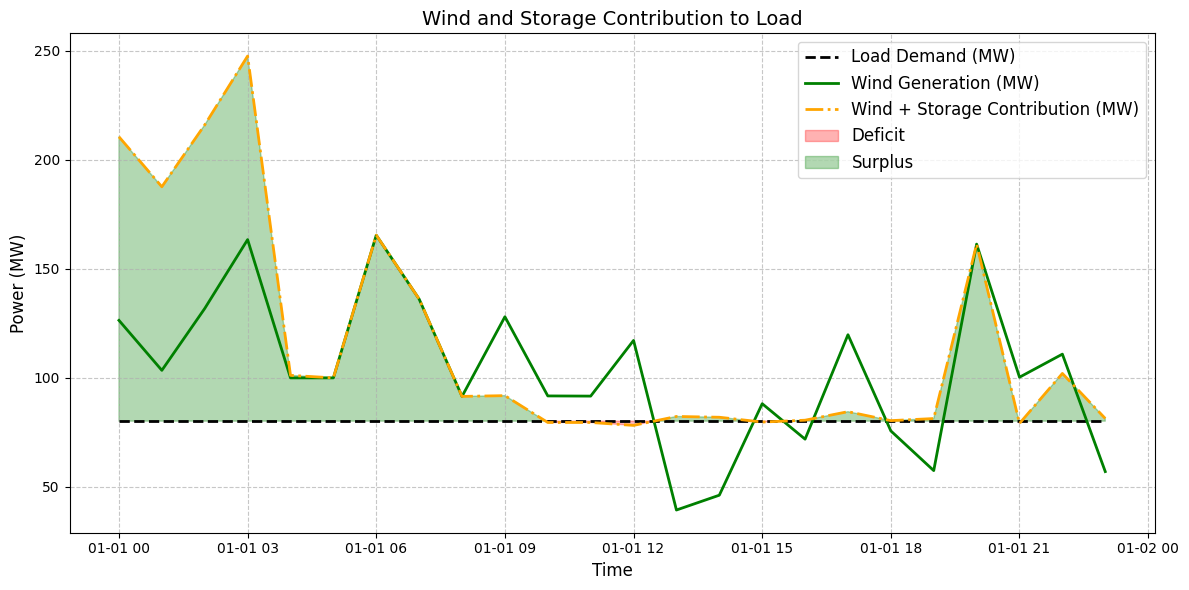

In [16]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the network
network = pypsa.Network()

# Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (wind generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)

# Generate a realistic wind profile
np.random.seed(42)  # For reproducibility
base_wind_speed = 0.6  # Average capacity factor (60%)
variability = 0.2  # Wind speed variability
wind_profile = pd.Series(
    base_wind_speed + variability * np.random.randn(len(hours)),
    index=hours
).clip(lower=0, upper=1)  # Ensure the values are between 0 and 1

# Add Wind Generator
p_nom_wind = 190  # Nominal power (MW)
network.add("Generator", "Wind Generator", bus="bus1", p_nom=p_nom_wind, p_max_pu=wind_profile, carrier="wind")

# Add Inverter (as a link)
inverter_efficiency = 0.95
network.add("Link", "Inverter", bus0="bus1", bus1="bus2", p_nom=p_nom_wind * 2, efficiency=inverter_efficiency, carrier="inverter")

# Define constant load demand
p_load = 80  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)  # Constant across all snapshots

# Add Load
network.add("Load", "Load", bus="bus2", p_set=load_demand)

# Add Storage Unit
network.add(
    "StorageUnit",
    "Battery Storage",
    bus="bus1",
    p_nom=200,  # Maximum charging/discharging power (MW)
    max_hours=4,  # Max energy storage in hours
    efficiency_store=0.9,  # Charging efficiency
    efficiency_dispatch=0.9,  # Discharging efficiency
    state_of_charge_initial=400,  # Initial state of charge (MWh)
    carrier="battery",
)

# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

# Extract results
wind_generation = wind_profile * p_nom_wind * inverter_efficiency  # Wind generation after inverter
storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
storage_charging = storage_dispatch.clip(upper=0)  # Charging (negative values)
storage_discharging = storage_dispatch.clip(lower=0)  # Discharging (positive values)
total_to_load = wind_generation + storage_dispatch  # Combined wind and storage contribution

# Plot 1: Wind Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.title("Wind Generation Profile", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Storage Activity
plt.figure(figsize=(12, 6))
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="blue", alpha=0.6, width=0.03)
plt.title("Storage Charging and Discharging", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Total Contribution to Load
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.plot(hours, total_to_load, label="Wind + Storage Contribution (MW)", color="orange", linestyle="-.", linewidth=2)
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load < load_demand), interpolate=True, color="red", alpha=0.3, label="Deficit")
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load >= load_demand), interpolate=True, color="green", alpha=0.3, label="Surplus")
plt.title("Wind and Storage Contribution to Load", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


<span style="color: red; font-size: 2em; font-weight: bold;">Step by step code</span>

# Step 1: Setting Up the Environment

## Install PyPSA

In [ ]:
#!pip install pypsa

In [1]:
# Import pypsa 
import pypsa

## Additional Libraries
PyPSA may require other libraries for plotting and numerical operations:

In [2]:
# pip install numpy pandas matplotlib networkx

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Creating Your Network:

## Creating the Network

In [4]:
# Create an empty network
network = pypsa.Network()

Network: Represents the electrical network.

## Add buses

In [5]:
# Add 2 buses
network.add("Bus", "bus1", carrier="DC")  # DC side (wind generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
bus1,1.0,,0.0,0.0,DC,,1.0,0.0,inf,PQ,
bus2,1.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,


Bus: A bus represents a point in the system where power is injected or consumed. It’s where all electrical components (load, generator) connect.

v_nom: This is the nominal voltage of the bus. For simplicity, we set it to 20 kV.

## Define time steps for the simulation

In [6]:
# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)
hours

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')

## Add a Generator: Wind Generator

In [7]:
# Generate a synthetic/realistic wind profile
np.random.seed(42)  # For reproducibility

base_wind_speed = 0.6  # Average capacity factor (60%)
variability = 0.2  # Wind speed variability

wind_profile = pd.Series(
    base_wind_speed + variability * np.random.randn(len(hours)),
    index=hours
).clip(lower=0, upper=1)  # Ensure the values are between 0 and 1

wind_profile

2023-01-01 00:00:00    0.699343
2023-01-01 01:00:00    0.572347
2023-01-01 02:00:00    0.729538
2023-01-01 03:00:00    0.904606
2023-01-01 04:00:00    0.553169
2023-01-01 05:00:00    0.553173
2023-01-01 06:00:00    0.915843
2023-01-01 07:00:00    0.753487
2023-01-01 08:00:00    0.506105
2023-01-01 09:00:00    0.708512
2023-01-01 10:00:00    0.507316
2023-01-01 11:00:00    0.506854
2023-01-01 12:00:00    0.648392
2023-01-01 13:00:00    0.217344
2023-01-01 14:00:00    0.255016
2023-01-01 15:00:00    0.487542
2023-01-01 16:00:00    0.397434
2023-01-01 17:00:00    0.662849
2023-01-01 18:00:00    0.418395
2023-01-01 19:00:00    0.317539
2023-01-01 20:00:00    0.893130
2023-01-01 21:00:00    0.554845
2023-01-01 22:00:00    0.613506
2023-01-01 23:00:00    0.315050
Freq: H, dtype: float64

In [8]:
# Add a generator to Bus 1 
p_nom_wind = 150  # Nominal power (MW)
network.add("Generator", 
            "Wind Generator", 
            bus="bus1", 
            p_nom=p_nom_wind, 
            p_max_pu=wind_profile, carrier="wind")

# p_max_pu=wind_profile(%)*p_nom

Generator: Represents a generator that supplies power to the grid.

    bus: This defines which bus the generator is connected to, in this case, Bus1. Connected to DC bus
    p_nom: Nominal power capacity (MW)
    p_max_pu=solar_profile,  # Time series for solar output

## Add Storage Unit

In [9]:
network.add(
    "StorageUnit",
    "Battery Storage",
    bus="bus1",
    p_nom=200,  # Maximum charging/discharging power (MW)
    max_hours=4,  # Max energy storage in hours
    efficiency_store=0.9,  # Charging efficiency
    efficiency_dispatch=0.9,  # Discharging efficiency
    state_of_charge_initial=400,  # Initial state of charge (MWh)
    carrier="battery",
)

## Add Inverter (as a link)

In [10]:
# Add Inverter (as a link) between Bus 1 (DC) and Bus 2 (AC)
inverter_efficiency = 0.95
network.add("Link", 
            "Inverter", 
            bus0="bus1", 
            bus1="bus2", 
            p_nom=p_nom_wind * 2, 
            efficiency=inverter_efficiency, 
            carrier="inverter")


            bus0="bus1"  # DC input
            bus1="bus2"  # AC output

## Add a Load
A load consumes power from the grid. Let’s add a load to Bus2 that will consume some power.

In [11]:
# Define constant load demand
p_load = 70  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)  # Constant across all snapshots

# Add a load to Bus 2
network.add("Load", 
            "Load", 
            bus="bus2", 
            p_set=load_demand)

Load: Represents a power consumer.

bus: The bus where the load is connected. # Connected to AC bus

p_set: Constant load demand (MW)

# Step 3: Check results

In [12]:
# Print the network
print(network)

PyPSA Network
Components:
 - Bus: 2
 - Generator: 1
 - Link: 1
 - Load: 1
 - StorageUnit: 1
Snapshots: 24


# Step 4: Solving the Network
PyPSA includes tools for solving network power flows and optimization problems.

## Power Flow Calculation
After setting up the network, calculate the power flow:
We will now solve the network to find the power flow, voltages at each bus, and the power transmitted through the lines.

In [13]:
# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.41s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


('ok', 'optimal')

## Extract results

You can inspect the power flows on lines and outputs of generators:

In [14]:
# Extract results
wind_generation = wind_profile * p_nom_wind * inverter_efficiency  # Wind generation after inverter

storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
storage_charging = storage_dispatch.clip(upper=0)  # Charging (negative values)
storage_discharging = storage_dispatch.clip(lower=0)  # Discharging (positive values)

total_to_load = wind_generation + storage_dispatch  # Combined wind and storage contribution


# Power Visualization

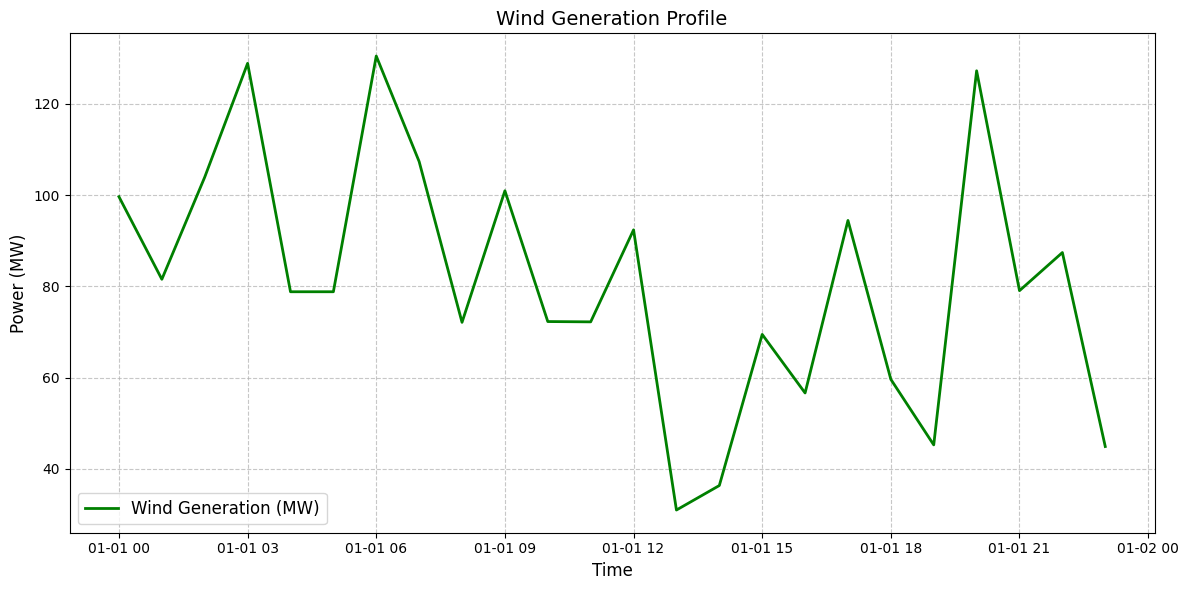

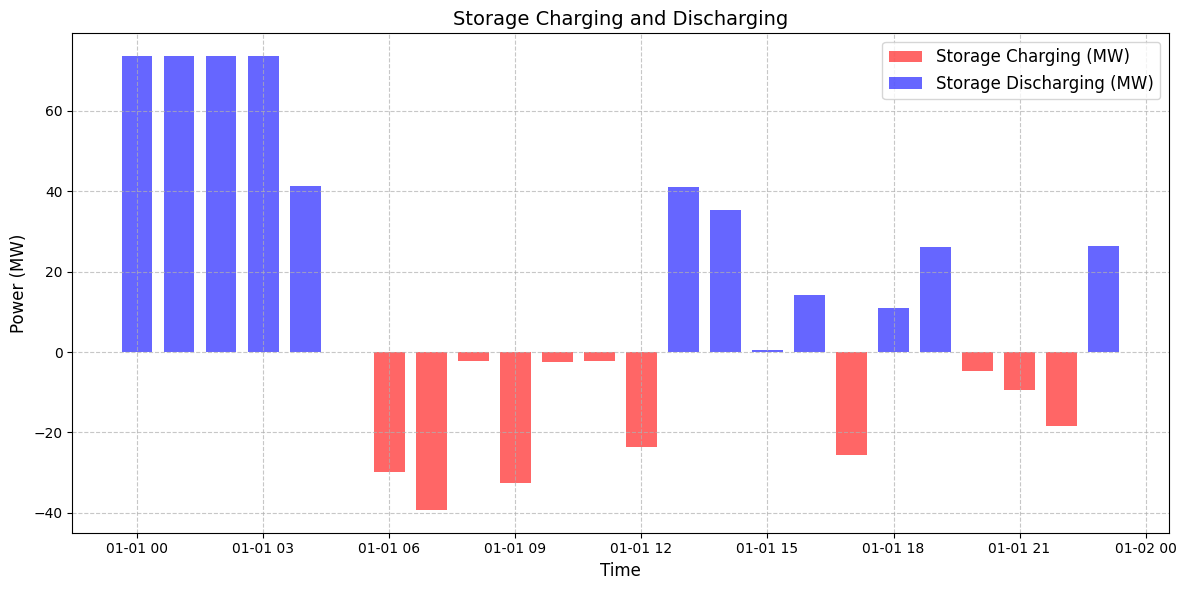

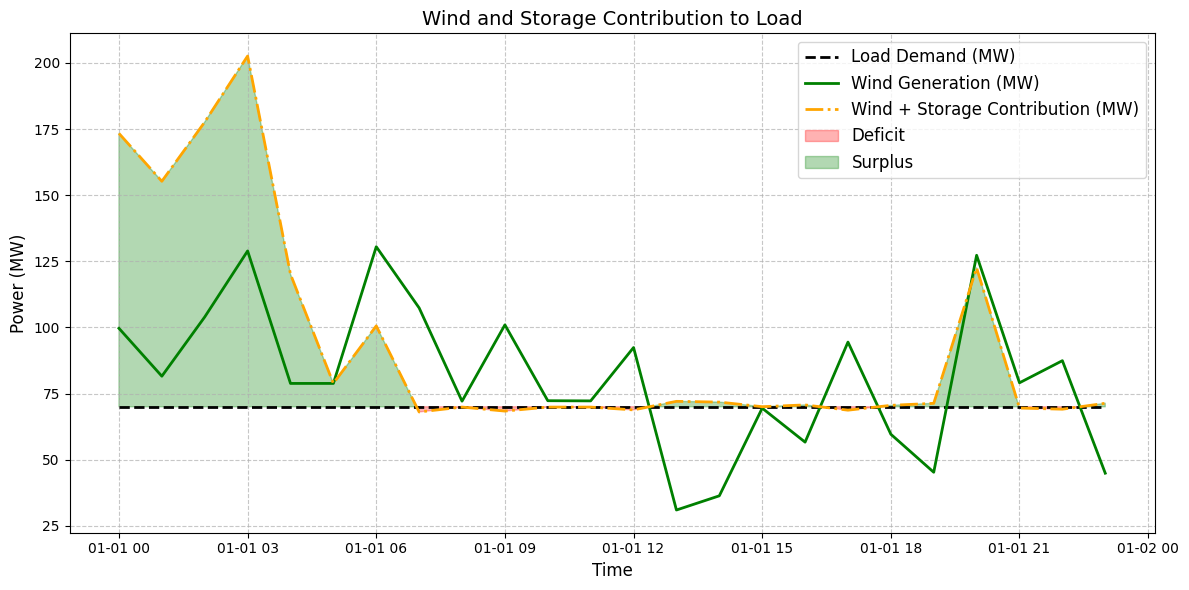

In [15]:
# Plot 1: Wind Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.title("Wind Generation Profile", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Storage Activity
plt.figure(figsize=(12, 6))
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="blue", alpha=0.6, width=0.03)
plt.title("Storage Charging and Discharging", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Total Contribution to Load
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.plot(hours, total_to_load, label="Wind + Storage Contribution (MW)", color="orange", linestyle="-.", linewidth=2)
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load < load_demand), interpolate=True, color="red", alpha=0.3, label="Deficit")
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load >= load_demand), interpolate=True, color="green", alpha=0.3, label="Surplus")
plt.title("Wind and Storage Contribution to Load", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
